In [10]:

import numpy as np
import pandas as pd

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pyreadr



In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

In [13]:
# Read R data

df_FaultFree = pyreadr.read_r('.\data\Tenesee Failure Data\TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r('.\data\Tenesee Failure Data\TEP_Faulty_Training.RData')['faulty_training']
df = pd.concat([df_FaultFree,df_Faulty]) 
df.head()


,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [15]:
print(df.columns)

Index(['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2',
       'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'],
      dtype='object')


In [37]:
df.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
489520,20.0,49.0,21,0.24377,3651.9,4540.4,9.2108,27.191,41.846,2708.9,...,53.451,23.787,62.555,22.741,37.901,39.554,46.742,48.554,41.069,16.200
489521,20.0,49.0,22,0.24307,3657.5,4489.5,9.3701,26.995,42.070,2712.3,...,54.060,23.856,63.258,22.618,37.527,40.124,49.442,48.641,41.446,18.380
489522,20.0,49.0,23,0.29887,3656.5,4570.4,9.4066,26.358,42.190,2713.6,...,53.797,29.169,62.223,22.717,39.090,40.582,47.458,48.500,40.996,15.898
489523,20.0,49.0,24,0.29813,3644.1,4494.5,9.5156,27.167,42.693,2715.8,...,54.705,29.241,59.866,22.800,39.049,40.647,42.525,48.480,41.664,17.666
489524,20.0,49.0,25,0.23165,3669.4,4527.5,9.4437,26.841,42.445,2716.1,...,54.063,23.013,61.879,22.739,37.083,45.084,44.505,48.837,41.473,16.853


# 1) Data Preprocesing

In [21]:

# generate sets of sequences from data

def SlidingWindow(df, w, s):
    X = []
    Y = []
    # Iterate through the rows of the DataFrame in steps of size s
    for i in range(0, len(df)-w, s):
        # Extract a window of width w from the DataFrame, starting at row i
        x = np.array(df.iloc[i:i+w, 3:])
        # Extract the target value (faultNumber) for the last row of the window
        y = np.array(df.iloc[i+w-1, 0])
        # Append the window and target value to the X and Y lists, respectively
        X.append(x)
        Y.append(y)

    # Convert the X and Y lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# window for the sequences
w = 20

# Step between sequences
s = 10

X = []
Y = []

# Loop through all faultNumbers except 3, 9, and 15, and all simulationRuns from 1 to 50
for j in [x for x in range(0,21) if x not in [9,15]]:
    for i in range(1, 50):
        # Select the rows from DataFrame DF with the current faultNumber and simulationRun, and remove highly correlated columns
        df = DF[(DF['faultNumber']==j) & (DF['simulationRun']==i) & (DF['sample']>20)]
        # Apply sliding window with window size w and step size s to the current DataFrame
        x_temp, y_temp = SlidingWindow(df, w, s)
        # Append the resulting windowed data and target values to the X and Y lists, respectively
        X.append(x_temp)
        Y.append(y_temp)
    
# Convert the X and Y lists to numpy arrays, and reshape them to the correct dimensions
X = np.array(X).reshape((-1, w, x_temp.shape[-1]))
Y = np.array(Y).reshape((-1,))
print(X.shape)
print(Y.shape)


(42826, 20, 52)
(42826,)


In [29]:
# scale dataset


# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = DF[DF['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 3:]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)
X_sc = sc.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

c:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [30]:
# One hot encoding labels

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_enc = enc.transform(Y.reshape(-1, 1))
print(np.unique(Y))
print(Y_enc)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 16. 17. 18. 19.
 20.]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


c:\Users\david\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
# train test Split 

from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(X_sc,Y_enc,test_size=0.2,random_state=40)

print(y_train.shape)
print(y_test.shape)
print(x_train.shape)
print(x_test.shape)

(34260, 19)
(8566, 19)
(34260, 20, 52)
(8566, 20, 52)


# 2)| Training

In [59]:
from tensorflow.keras.models import Sequential

model = Sequential([

    LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2]),activation='relu'),
    
    Dense(100,activation='relu'),
    Dropout(0.5) ,
    Dense(y_train.shape[1],activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Epoch 1/200
133/134 [============================>.] - ETA: 0s - loss: 3.4171 - accuracy: 0.3035
Epoch 1: accuracy improved from -inf to 0.30432, saving model to best_model.h5
134/134 [==============================] - 5s 26ms/step - loss: 3.4144 - accuracy: 0.3043 - val_loss: 1.7927 - val_accuracy: 0.5407
Epoch 2/200
132/134 [============================>.] - ETA: 0s - loss: 2.2944 - accuracy: 0.5028
Epoch 2: accuracy improved from 0.30432 to 0.50263, saving model to best_model.h5
134/134 [==============================] - 3s 22ms/step - loss: 2.2909 - accuracy: 0.5026 - val_loss: 1.4940 - val_accuracy: 0.5895
Epoch 3/200
133/134 [============================>.] - ETA: 0s - loss: 1.7054 - accuracy: 0.5684
Epoch 3: accuracy improved from 0.50263 to 0.56862, saving model to best_model.h5
134/134 [==============================] - 3s 21ms/step - loss: 1.7039 - accuracy: 0.5686 - val_loss: 1.2989 - val_accuracy: 0.6226
Epoch 4/200
133/134 [============================>.] - ETA: 0s - loss:

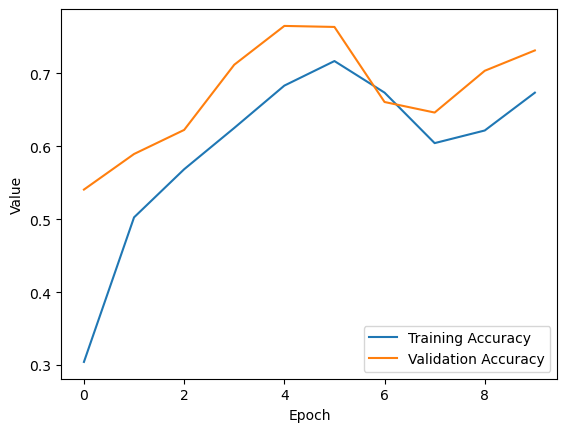

In [60]:
from keras.callbacks import EarlyStopping


# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Ruta donde se guardará el modelo
    monitor='accuracy',  # Métrica a monitorear
    verbose=1,  # Mostrar información en la consola
    save_best_only=True,  # Solo guardar el modelo si es el mejor hasta ahora
   
)


# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(x_train, y_train, epochs=200, batch_size=256, validation_data=(x_test, y_test), callbacks=[checkpoint,early_stop])

# Plot the training history for loss and accuracy

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [61]:
from tensorflow.keras.models import Sequential

model_2 = Sequential([

    LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2]),activation='relu'),
    
    Dense(300,activation='relu'),
    Dropout(0.2) ,
    Dense(y_train.shape[1],activation='softmax')
])

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Epoch 1/200
134/134 [==============================] - ETA: 0s - loss: 2.6439 - accuracy: 0.4692
Epoch 1: accuracy improved from -inf to 0.46918, saving model to best_model.h5
134/134 [==============================] - 6s 35ms/step - loss: 2.6439 - accuracy: 0.4692 - val_loss: 4.3315 - val_accuracy: 0.5773
Epoch 2/200
134/134 [==============================] - ETA: 0s - loss: 3.4577 - accuracy: 0.5476
Epoch 2: accuracy improved from 0.46918 to 0.54758, saving model to best_model.h5
134/134 [==============================] - 4s 32ms/step - loss: 3.4577 - accuracy: 0.5476 - val_loss: 1.2084 - val_accuracy: 0.6490
Epoch 3/200
133/134 [============================>.] - ETA: 0s - loss: 1.1433 - accuracy: 0.6477
Epoch 3: accuracy improved from 0.54758 to 0.64775, saving model to best_model.h5
134/134 [==============================] - 4s 31ms/step - loss: 1.1438 - accuracy: 0.6478 - val_loss: 0.8789 - val_accuracy: 0.7159
Epoch 4/200
133/134 [============================>.] - ETA: 0s - loss:

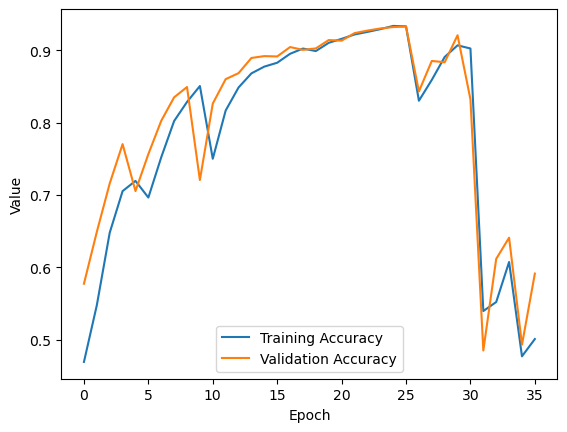

In [62]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)
# Crear la callback de ModelCheckpoint
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Ruta donde se guardará el modelo
    monitor='accuracy',  # Métrica a monitorear
    verbose=1,  # Mostrar información en la consola
    save_best_only=True,  # Solo guardar el modelo si es el mejor hasta ahora
    
)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history_2 = model_2.fit(x_train, y_train, epochs=200, batch_size=256, validation_data=(x_test, y_test), callbacks=[checkpoint,early_stop])

# Plot the training history for loss and accuracy

plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

model_3 = Sequential([

    LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]),activation='relu'),
    LSTM(128,activation='relu'),
    
    Dense(300,activation='relu'),
    Dense(200,activation='relu'),
    Dense(100,activation='relu'),
    Dropout(0.2) ,
    
    Dense(y_train.shape[1],activation='softmax')
])

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/200
134/134 [==============================] - ETA: 0s - loss: 2.3444 - accuracy: 0.3796
Epoch 1: accuracy improved from -inf to 0.37963, saving model to best_model.h5
134/134 [==============================] - 13s 82ms/step - loss: 2.3444 - accuracy: 0.3796 - val_loss: 1.8100 - val_accuracy: 0.4993
Epoch 2/200
134/134 [==============================] - ETA: 0s - loss: 1.5414 - accuracy: 0.5178
Epoch 2: accuracy improved from 0.37963 to 0.51781, saving model to best_model.h5
134/134 [==============================] - 10s 78ms/step - loss: 1.5414 - accuracy: 0.5178 - val_loss: 1.2309 - val_accuracy: 0.5860
Epoch 3/200
134/134 [==============================] - ETA: 0s - loss: 1.2506 - accuracy: 0.5769
Epoch 3: accuracy improved from 0.51781 to 0.57685, saving model to best_model.h5
134/134 [==============================] - 12s 90ms/step - loss: 1.2506 - accuracy: 0.5769 - val_loss: 1.2644 - val_accuracy: 0.5976
Epoch 4/200
134/134 [==============================] - ETA: 0s - lo

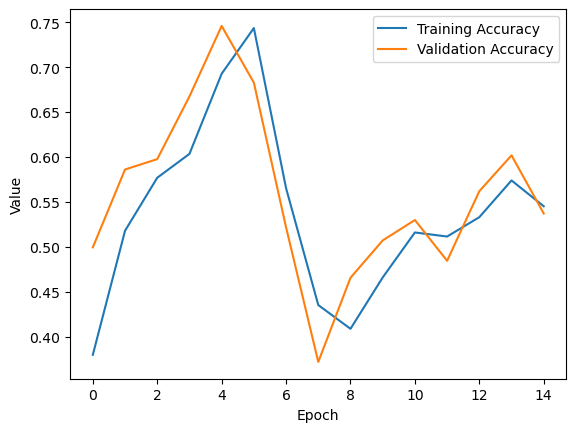

In [67]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Ruta donde se guardará el modelo
    monitor='accuracy',  # Métrica a monitorear
    verbose=1,  # Mostrar información en la consola
    save_best_only=True,  # Solo guardar el modelo si es el mejor hasta ahora
   
)



# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history_3 = model_3.fit(x_train, y_train, epochs=200, batch_size=256, validation_data=(x_test, y_test), callbacks=[checkpoint,early_stop])

# Plot the training history for loss and accuracy

plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [69]:
# Asumiendo que 'history_2' es el historial del entrenamiento de tu segundo modelo
best_accuracy = np.max(history_2.history['accuracy'])
best_val_accuracy = np.max(history_2.history['val_accuracy'])

# Imprime el mejor accuracy alcanzado en los datos de entrenamiento y validación
print(f'For Model 2 : Mejor accuracy en entrenamiento: {best_accuracy * 100:.2f}%')
print(f'For Model 2 : Mejor accuracy en validación: {best_val_accuracy * 100:.2f}%')

# Asumiendo que 'history_2' es el historial del entrenamiento de tu segundo modelo
best_accuracy = np.max(history.history['accuracy'])
best_val_accuracy = np.max(history.history['val_accuracy'])

# Imprime el mejor accuracy alcanzado en los datos de entrenamiento y validación
print(f'For Model 1 : Mejor accuracy en entrenamiento: {best_accuracy * 100:.2f}%')
print(f'For Model 1 : Mejor accuracy en validación: {best_val_accuracy * 100:.2f}%')

# Asumiendo que 'history_2' es el historial del entrenamiento de tu segundo modelo
best_accuracy = np.max(history_3.history['accuracy'])
best_val_accuracy = np.max(history_3.history['val_accuracy'])

# Imprime el mejor accuracy alcanzado en los datos de entrenamiento y validación
print(f'For Model 3 : Mejor accuracy en entrenamiento: {best_accuracy * 100:.2f}%')
print(f'For Model 3 : Mejor accuracy en validación: {best_val_accuracy * 100:.2f}%')

For Model 2 : Mejor accuracy en entrenamiento: 93.36%
For Model 2 : Mejor accuracy en validación: 93.28%
For Model 1 : Mejor accuracy en entrenamiento: 71.70%
For Model 1 : Mejor accuracy en validación: 76.52%
For Model 3 : Mejor accuracy en entrenamiento: 74.36%
For Model 3 : Mejor accuracy en validación: 74.60%
